In [3]:
!pip install --upgrade tensorflow==2.19.0 tensorflowjs keras-tuner tensorflow-datasets


In [4]:
%pip install tensorflowjs

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.19.0'

In [8]:
!pip install tensorflow-decision-forests==1.12.0

In [9]:
#Funcion de normalizacion para los datos (Pasar valor de los pixeles de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

In [10]:
!pip install tensorflow-datasets

In [11]:
import tensorflow_datasets as tfds
import math



In [12]:
#Descargar set de datos de MNIST (Numeros escritos a mano, etiquetados)
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [13]:
datos

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [14]:
#Etiquetas de las 10 categorias posibles (simplemente son los numeros del 0 al 9)
nombres_clases = metadatos.features['label'].names

In [15]:
nombres_clases

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [16]:
#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

In [17]:
datos_entrenamiento

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math
from kerastuner import RandomSearch
from tensorflow import keras


/tmp/ipython-input-118104268.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [20]:
num_ej_entrenamiento = metadatos.splits['train'].num_examples
num_ej_pruebas = metadatos.splits['test'].num_examples
TAMANO_LOTE = 32

In [21]:
# Shuffle y batching
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)


In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### KerasTuner

In [23]:
def build_model(hp):
    modelo = keras.Sequential()
    modelo.add(keras.layers.Flatten(input_shape=(28,28,1)))

    # Capas densas entre 1 y 3
    for i in range(hp.Int('num_layers', 1, 3)):
        modelo.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(hp.Float(f'l2_{i}', 0.0, 0.01, step=0.001))
        ))
        modelo.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    modelo.add(keras.layers.Dense(10, activation='softmax'))

    modelo.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo

In [24]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,            # puedes aumentar según tu tiempo
    executions_per_trial=1,
    directory='mnist_tuner',
    project_name='red_regular'
)

Reloading Tuner from mnist_tuner/red_regular/tuner0.json


In [25]:
tuner.search(
    datos_entrenamiento,
    epochs=10,
    validation_data=datos_pruebas,
    steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),
    callbacks=[early_stop]
)

In [26]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
print("Mejores hiperparámetros encontrados:")
print(best_hp.values)

Mejores hiperparámetros encontrados:
{'num_layers': 3, 'units_0': 256, 'l2_0': 0.008, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.0003305478759754872, 'units_1': 128, 'l2_1': 0.0, 'dropout_1': 0.2, 'units_2': 384, 'l2_2': 0.003, 'dropout_2': 0.2}


In [28]:
historial = best_model.fit(
    datos_entrenamiento,
    epochs=20,
    validation_data=datos_pruebas,
    steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),
    callbacks=[early_stop]
)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9568 - loss: 0.2561 - val_accuracy: 0.9720 - val_loss: 0.2154
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9577 - loss: 0.2605 - val_accuracy: 0.9704 - val_loss: 0.2196
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9572 - loss: 0.2600 - val_accuracy: 0.9717 - val_loss: 0.2173
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9606 - loss: 0.2527 - val_accuracy: 0.9725 - val_loss: 0.2103
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9596 - loss: 0.2549 - val_accuracy: 0.9716 - val_loss: 0.2159
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9583 - loss: 0.2606 - val_accuracy: 0.9727 - val_loss: 0.2064
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9585 - loss: 0.2558 - val_accuracy: 0.9707 - val_loss: 0.2229
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9608 - loss:

In [29]:
import matplotlib.pyplot as plt

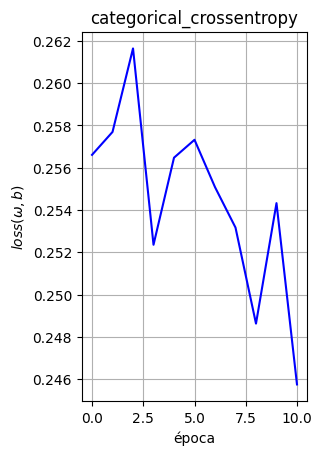

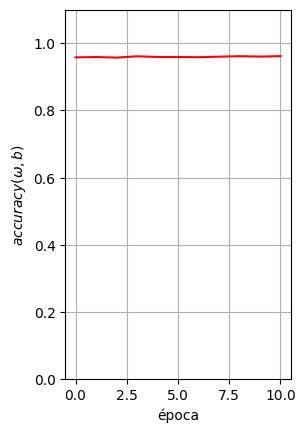

In [30]:
plt.subplot(1,2,1)
plt.plot(historial.epoch,historial.history['loss'], 'b',label='error')
plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$loss(\omega, b)$')
plt.grid(True)
#plt.legend(loc='upper right')
plt.show()

plt.subplot(1,2,2)
plt.plot(historial.epoch,historial.history['accuracy'], 'r',label='precisión')
#plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$accuracy(\omega, b)$')
plt.ylim([0,1.1])
plt.grid(True)
#plt.legend(loc='lower right')
plt.show()

#Exportar el modelo a TensorFlow.js

In [31]:
import sys
print("Python version:", sys.version)
import keras
print("Keras version:", keras.__version__)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Keras version: 3.10.0
TensorFlow version: 2.19.0


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files

# Guardar solo el mejor modelo durante el fit
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [38]:

# Entrenar el modelo usando los datasets de TFDS y el checkpoint
historial = best_model.fit(
    datos_entrenamiento,
    epochs=20,
    validation_data=datos_pruebas,
    steps_per_epoch=math.ceil(num_ej_entrenamiento / TAMANO_LOTE),
    callbacks=[checkpoint_cb, early_stop]
)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9597 - loss: 0.2521

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9597 - loss: 0.2521 - val_accuracy: 0.9726 - val_loss: 0.2139
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9590 - loss: 0.2549 - val_accuracy: 0.9699 - val_loss: 0.2242
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9610 - loss: 0.2508 - val_accuracy: 0.9722 - val_loss: 0.2150
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9621 - loss: 0.2486 - val_accuracy: 0.9669 - val_loss: 0.2282
Epoch 5/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9594 - loss: 0.2543

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9594 - loss: 0.2543 - val_accuracy: 0.9734 - val_loss: 0.2074
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9617 - loss: 0.2482 - val_accuracy: 0.9716 - val_loss: 0.2052
Epoch 7/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9592 - loss: 0.2513

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9592 - loss: 0.2513 - val_accuracy: 0.9746 - val_loss: 0.2107
Epoch 8/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9613 - loss: 0.2450

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9613 - loss: 0.2450 - val_accuracy: 0.9754 - val_loss: 0.2047
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9611 - loss: 0.2451 - val_accuracy: 0.9704 - val_loss: 0.2151
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9633 - loss: 0.2401 - val_accuracy: 0.9741 - val_loss: 0.2066
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9607 - loss: 0.2475 - val_accuracy: 0.9739 - val_loss: 0.2056
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9623 - loss: 0.2457 - val_accuracy: 0.9715 - val_loss: 0.2072
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9611 - loss: 0.2448 - val_accuracy: 0.9728 - val_loss: 0.2140


In [39]:

# Descargar el archivo al local
files.download('best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>